In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Sample data
data = [
    (1, "Male", "New York", 50000),
    (2, "Female", "California", 65000),
    (3, "Male", "Texas", 55000),
    (4, "Female", "New York", 70000),
    (5, "Male", "California", 60000),
    (6, "Female", "Texas", 58000),
    (7, "Male", "New York", 52000),
    (8, "Female", "California", 68000)
]

spark = SparkSession.builder.master("local[*]").appName("testing testing 123").getOrCreate()

df = spark.createDataFrame(data, ["id", "gender", "state", "salary"])


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
26/01/13 14:29:33 WARN Utils: Your hostname, Yadvendras-MacBook-Pro.local, resolves to a loopback address: 127.0.0.1; using 172.16.0.247 instead (on interface en0)
26/01/13 14:29:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/01/13 14:29:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# Pipeline stages
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
state_indexer = StringIndexer(inputCol="state", outputCol="state_index")
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded")
state_encoder = OneHotEncoder(inputCol="state_index", outputCol="state_encoded")

assembler = VectorAssembler(
    inputCols=["gender_encoded", "state_encoded"],
    outputCol="features"
)

pipeline = Pipeline(stages=[
    gender_indexer,
    state_indexer,
    gender_encoder,
    state_encoder,
    assembler
])

In [5]:
# Fit and transform
model = pipeline.fit(df)
transformed_df = model.transform(df)

In [6]:
# Get the actual feature names after encoding
# Gender has 2 categories -> 1 encoded feature (drop last)
# State has 3 categories -> 2 encoded features (drop last)
gender_categories = model.stages[0].labels  # From StringIndexer
state_categories = model.stages[1].labels   # From StringIndexer


In [7]:
# Create feature name mapping
feature_names = []

In [8]:
# Gender features (one-hot encoded, last category dropped)
for i in range(len(gender_categories) - 1):
    feature_names.append(f"gender_{gender_categories[i]}")

In [9]:
# State features (one-hot encoded, last category dropped)
for i in range(len(state_categories) - 1):
    feature_names.append(f"state_{state_categories[i]}")

print("Feature names after encoding:", feature_names)

Feature names after encoding: ['gender_Female', 'state_California', 'state_New York']


26/01/13 20:49:38 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 920018 ms exceeds timeout 120000 ms
26/01/13 20:49:38 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/13 20:49:40 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:359)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$

In [10]:
# Convert to numpy arrays
pandas_df = transformed_df.select("features", "salary").toPandas()
X = np.array([row['features'].toArray() for idx, row in pandas_df.iterrows()])
y = pandas_df['salary'].values

In [11]:
# Train XGBoost
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)


In [12]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes

In [ ]:
model.stages[1]

StringIndexerModel: uid=StringIndexer_7d4c17ef24f2, handleInvalid=error

26/01/13 14:28:51 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:359)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:81)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:674)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1324)
	at org.apache.spark.executor.Executor.$anonfun$heartbeater$1(Executor.scala:322)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.scala:18)
	at org.apache.spark.util.Utils$.logUncaughtExceptions(Utils.scala:1941

In [13]:
# Get feature importance
# Method 1: Weight-based importance (number of times feature is used)
importance_weight = xgb_model.feature_importances_

# Method 2: Gain-based importance (average gain of splits using the feature)
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')

# Method 3: Cover-based importance (average coverage of splits using the feature)
importance_cover = xgb_model.get_booster().get_score(importance_type='cover')

In [14]:
# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Weight': importance_weight,
})


In [15]:
# Sort by importance
importance_df = importance_df.sort_values('Importance_Weight', ascending=False)

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)
print(importance_df.to_string(index=False))



FEATURE IMPORTANCE
         Feature  Importance_Weight
   gender_Female           0.923187
state_California           0.073382
  state_New York           0.003431



Feature importance plot saved as 'feature_importance.png'


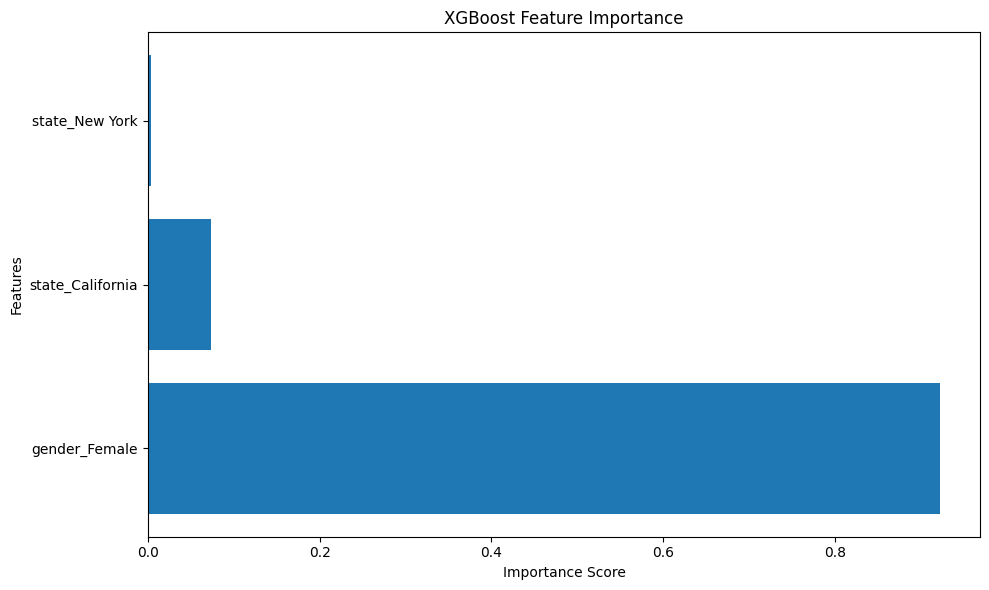

In [16]:
# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance_Weight'])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("\nFeature importance plot saved as 'feature_importance.png'")

XGBoost built-in plot saved as 'xgb_feature_importance.png'


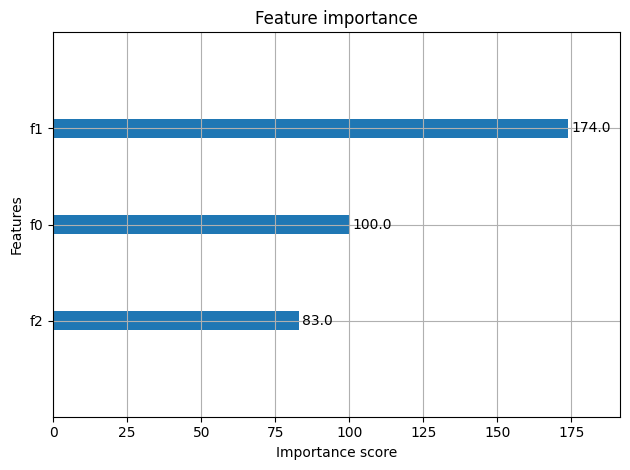

In [17]:
# Alternative: Use XGBoost's built-in plot
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.tight_layout()
plt.savefig('xgb_feature_importance.png')
print("XGBoost built-in plot saved as 'xgb_feature_importance.png'")


In [18]:
# Get detailed importance scores for all types
print("\n" + "="*50)
print("DETAILED IMPORTANCE SCORES")
print("="*50)

for idx, feature_name in enumerate(feature_names):
    feature_key = f'f{idx}'
    gain = importance_gain.get(feature_key, 0)
    cover = importance_cover.get(feature_key, 0)
    weight = importance_weight[idx]
    
    print(f"{feature_name}:")
    print(f"  Weight: {weight:.4f}")
    print(f"  Gain: {gain:.4f}")
    print(f"  Cover: {cover:.4f}")
    print()


DETAILED IMPORTANCE SCORES
gender_Female:
  Weight: 0.9232
  Gain: 15717992.0000
  Cover: 6.0000

state_California:
  Weight: 0.0734
  Gain: 1249388.7500
  Cover: 3.1494

state_New York:
  Weight: 0.0034
  Gain: 58413.8867
  Cover: 3.0000



In [19]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
train_df.count(), test_df.count(), df.count()

(7, 1, 8)

26/01/13 14:14:41 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1017180 ms exceeds timeout 120000 ms
26/01/13 14:14:41 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/13 14:14:41 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:359)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
# from sparkxgb import XGBoostClassifier
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create SparkSession
# spark = SparkSession.builder \
#     .appName("XGBoostClassificationExample") \
#     .getOrCreate()

spark = SparkSession.builder.master("local[*]").appName("XGBoostClassificationExample").getOrCreate()

# Sample data for loan approval prediction
data = [
    (1, "Male", "Engineer", 75000, 720, 5, "Approved"),
    (2, "Female", "Doctor", 95000, 780, 3, "Approved"),
    (3, "Male", "Teacher", 45000, 650, 8, "Rejected"),
    (4, "Female", "Engineer", 82000, 740, 4, "Approved"),
    (5, "Male", "Artist", 35000, 580, 12, "Rejected"),
    (6, "Female", "Lawyer", 105000, 800, 2, "Approved"),
    (7, "Male", "Teacher", 48000, 670, 7, "Rejected"),
    (8, "Female", "Engineer", 78000, 730, 4, "Approved"),
    (9, "Male", "Doctor", 92000, 760, 3, "Approved"),
    (10, "Female", "Artist", 38000, 600, 10, "Rejected"),
    (11, "Male", "Lawyer", 98000, 790, 2, "Approved"),
    (12, "Female", "Teacher", 46000, 660, 6, "Rejected"),
    (13, "Male", "Engineer", 80000, 750, 3, "Approved"),
    (14, "Female", "Doctor", 88000, 770, 4, "Approved"),
    (15, "Male", "Artist", 32000, 570, 15, "Rejected"),
]

df = spark.createDataFrame(data, 
    ["id", "gender", "occupation", "income", "credit_score", "years_employed", "loan_status"])

print("="*60)
print("SAMPLE DATA")
print("="*60)
df.show()

# Check data statistics
print("\n" + "="*60)
print("NUMERICAL FEATURES STATISTICS")
print("="*60)
df.select("income", "credit_score", "years_employed").describe().show()

# PREPROCESSING PIPELINE

# Step 1: Index the target variable
label_indexer = StringIndexer(inputCol="loan_status", outputCol="label")

# Step 2: Index categorical features
gender_indexer = StringIndexer(inputCol="gender", outputCol="gender_index")
occupation_indexer = StringIndexer(inputCol="occupation", outputCol="occupation_index")

# Step 3: One-Hot Encode categorical features
gender_encoder = OneHotEncoder(inputCol="gender_index", outputCol="gender_encoded")
occupation_encoder = OneHotEncoder(inputCol="occupation_index", outputCol="occupation_encoded")

# Step 4: Assemble features WITHOUT scaling first (to see the difference)
assembler_unscaled = VectorAssembler(
    inputCols=["gender_encoded", "occupation_encoded", "income", "credit_score", "years_employed"],
    outputCol="features_unscaled"
)

# Step 5: Scale numerical features (OPTIONAL but recommended for some algorithms)
# Note: XGBoost is tree-based and doesn't require scaling, but we'll show both approaches
scaler = StandardScaler(
    inputCol="features_unscaled",
    outputCol="features",
    withStd=True,
    withMean=False  # Set to False for sparse vectors
)

# Create two pipelines: with and without scaling

# Pipeline WITHOUT scaling (recommended for XGBoost)
pipeline_no_scale = Pipeline(stages=[
    label_indexer,
    gender_indexer,
    occupation_indexer,
    gender_encoder,
    occupation_encoder,
    assembler_unscaled
])

# Pipeline WITH scaling (for comparison)
pipeline_with_scale = Pipeline(stages=[
    label_indexer,
    gender_indexer,
    occupation_indexer,
    gender_encoder,
    occupation_encoder,
    assembler_unscaled,
    scaler
])

print("\n" + "="*60)
print("PREPROCESSING - WITHOUT SCALING (Recommended for XGBoost)")
print("="*60)

# Fit and transform using pipeline without scaling
preprocessing_model = pipeline_no_scale.fit(df)
transformed_df = preprocessing_model.transform(df)

# Get feature names
gender_categories = preprocessing_model.stages[1].labels
occupation_categories = preprocessing_model.stages[2].labels

feature_names = []
for i in range(len(gender_categories) - 1):
    feature_names.append(f"gender_{gender_categories[i]}")
for i in range(len(occupation_categories) - 1):
    feature_names.append(f"occupation_{occupation_categories[i]}")
feature_names.extend(["income", "credit_score", "years_employed"])

print("Feature names:", feature_names)

# Show transformed data
transformed_df.select("id", "features_unscaled", "label", "loan_status").show(5, truncate=False)

# Split data
train_df, test_df = transformed_df.randomSplit([0.7, 0.3], seed=42)

print(f"\nTraining samples: {train_df.count()}")
print(f"Test samples: {test_df.count()}")

# Train XGBoost Classifier WITHOUT scaling
print("\n" + "="*60)
print("TRAINING XGBOOST CLASSIFIER (Without Scaling)")
print("="*60)

xgb_classifier = SparkXGBClassifier(
    features_col="features_unscaled",
    label_col="label",
    prediction_col="prediction",
    numRound=100,
    maxDepth=4,
    eta=0.1,
    objective="binary:logistic",
    eval_metric="logloss"
)

xgb_model = xgb_classifier.fit(train_df)

# Make predictions
predictions_df = xgb_model.transform(test_df)

print("\nPredictions:")
predictions_df.select("loan_status", "label", "prediction", "probability").show(truncate=False)

# Evaluate model
evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

accuracy = evaluator_accuracy.evaluate(predictions_df)
f1_score = evaluator_f1.evaluate(predictions_df)

print(f"\nModel Performance (Without Scaling):")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# Get feature importance
print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

booster = xgb_model.nativeBooster
importance_gain = booster.getScore("", "gain")

gain_dict = {}
for i in range(len(feature_names)):
    feature_key = f"f{i}"
    if feature_key in importance_gain:
        gain_dict[feature_names[i]] = float(importance_gain[feature_key])
    else:
        gain_dict[feature_names[i]] = 0.0

sorted_importance = sorted(gain_dict.items(), key=lambda x: x[1], reverse=True)
for feature, score in sorted_importance:
    print(f"{feature:25s}: {score:.4f}")

# Visualize feature importance
importance_df = pd.DataFrame(sorted_importance, columns=['Feature', 'Importance'])
importance_df = importance_df[importance_df['Importance'] > 0]  # Only show features that were used

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Features')
plt.title('XGBoost Feature Importance - Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('classification_feature_importance.png', dpi=300, bbox_inches='tight')
print("\nFeature importance plot saved!")

# NOW LET'S COMPARE WITH SCALING
print("\n" + "="*60)
print("TRAINING WITH SCALING (For Comparison)")
print("="*60)

preprocessing_model_scaled = pipeline_with_scale.fit(df)
transformed_df_scaled = preprocessing_model_scaled.transform(df)

train_df_scaled, test_df_scaled = transformed_df_scaled.randomSplit([0.7, 0.3], seed=42)

xgb_classifier_scaled = SparkXGBClassifier(
    features_col="features",  # Using scaled features
    label_col="label",
    prediction_col="prediction",
    numRound=100,
    maxDepth=4,
    eta=0.1,
    # objective="binary:logistic"
)

xgb_model_scaled = xgb_classifier_scaled.fit(train_df_scaled)
predictions_df_scaled = xgb_model_scaled.transform(test_df_scaled)

accuracy_scaled = evaluator_accuracy.evaluate(predictions_df_scaled)
f1_score_scaled = evaluator_f1.evaluate(predictions_df_scaled)

print(f"\nModel Performance (With Scaling):")
print(f"Accuracy: {accuracy_scaled:.4f}")
print(f"F1 Score: {f1_score_scaled:.4f}")

# Comparison
print("\n" + "="*60)
print("COMPARISON: SCALING vs NO SCALING")
print("="*60)
print(f"{'Metric':<20} {'Without Scaling':<20} {'With Scaling':<20}")
print("-" * 60)
print(f"{'Accuracy':<20} {accuracy:<20.4f} {accuracy_scaled:<20.4f}")
print(f"{'F1 Score':<20} {f1_score:<20.4f} {f1_score_scaled:<20.4f}")

print("\n" + "="*60)
print("KEY TAKEAWAYS")
print("="*60)
print("""
1. NUMERICAL FEATURE PREPROCESSING FOR XGBOOST:
   - Scaling is NOT required for tree-based models like XGBoost
   - XGBoost uses decision trees which are invariant to feature scaling
   - Saves computation time by skipping scaling step
   
2. WHEN TO USE SCALING:
   - Linear models (Logistic Regression, Linear SVM)
   - Distance-based algorithms (KNN, K-Means)
   - Neural Networks
   - Gradient Descent optimization
   
3. WHEN NOT TO USE SCALING:
   - Tree-based models (XGBoost, Random Forest, Decision Trees)
   - Tree-based models split on thresholds, not distances
   
4. OTHER NUMERICAL PREPROCESSING CONSIDERATIONS:
   - Handle missing values (imputation)
   - Handle outliers (clipping, transformation)
   - Feature engineering (log transform, polynomial features)
   - Feature interactions

5. CATEGORICAL vs NUMERICAL:
   - Categorical: Require encoding (StringIndexer + OneHotEncoder)
   - Numerical: Can be used directly in XGBoost (no scaling needed)
   - Both can be combined in VectorAssembler
""")

spark.stop()

SAMPLE DATA
+---+------+----------+------+------------+--------------+-----------+
| id|gender|occupation|income|credit_score|years_employed|loan_status|
+---+------+----------+------+------------+--------------+-----------+
|  1|  Male|  Engineer| 75000|         720|             5|   Approved|
|  2|Female|    Doctor| 95000|         780|             3|   Approved|
|  3|  Male|   Teacher| 45000|         650|             8|   Rejected|
|  4|Female|  Engineer| 82000|         740|             4|   Approved|
|  5|  Male|    Artist| 35000|         580|            12|   Rejected|
|  6|Female|    Lawyer|105000|         800|             2|   Approved|
|  7|  Male|   Teacher| 48000|         670|             7|   Rejected|
|  8|Female|  Engineer| 78000|         730|             4|   Approved|
|  9|  Male|    Doctor| 92000|         760|             3|   Approved|
| 10|Female|    Artist| 38000|         600|            10|   Rejected|
| 11|  Male|    Lawyer| 98000|         790|             2|   Appr

ValueError: Setting custom 'objective' param is not allowed in 'SparkXGBClassifier'.

26/01/15 05:04:21 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 904770 ms exceeds timeout 120000 ms
26/01/15 05:04:21 WARN SparkContext: Killing executors is not supported by current scheduler.
26/01/15 05:11:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:53)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:359)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:132)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$